In [1]:
import sys, os
#os.chdir('C:\\Users\\Steffi\\Desktop\\PSR\\Analysis')
sys.path.append(os.getcwd()+'/PyGazeAnalyser/')
import pygazeanalyser
from pygazeanalyser.edfreader import read_edf
# append Pygaz analyser folder, cloned from https://github.com/esdalmaijer/PyGazeAnalyser.git

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
%matplotlib inline

from statistics import mean
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kstest, wilcoxon

Exclusion: sub that has 38% missed trials in crowding (13), and subs with chance level accuracy in crowding (3,10,14), sub with <85% accuracy in visual search task (8), and crit spacing of 0.8 (7), misunderstood task (6) and fell asleep (15)

In [2]:
subjects = ['01','02','04','05','09','11','12','16','17','18']

## 1) Crowding Task

In [3]:
# Params
total_trials = 720
blocks = 5 #including one practice block
trials_block = total_trials/blocks
trials = total_trials - trials_block #number of trials excluding training
ecc = [4,8,12]
last_trials = 96 #number of trials to calculate critical distance

In [4]:
crowding_files = []
for sub in range(len(subjects)):
    #filename = os.path.join(os.getcwd(),'Data/output_crowding/data_crowding_pp_%s.csv' %(subjects[sub]))
    filename = 'C:\\Users\\Steffi\\Desktop\\PSR\\Data\\output_crowding\\data_crowding_pp_%s.csv' %(subjects[sub])
    crowding_files.append(filename)

**Missed trials**

In [5]:
missed_trials = np.zeros(len(subjects))

for sub in range(len(subjects)):
    
    data_sub = pd.read_csv(crowding_files[sub], sep='\t')
    data_sub = data_sub.loc[(trials_block):(total_trials-1)]
    miss = []
    miss = data_sub['key_pressed'].isna().sum() #easier way to count NaNs in dataframe
            
    missed_trials[sub] = miss/len(data_sub)#len(miss)/len(data_sub)

In [6]:
#Percentage of missed trials per participant
print(missed_trials)

[0.07118056 0.02083333 0.04513889 0.00173611 0.04861111 0.03472222
 0.13888889 0.01388889 0.00173611 0.02256944]


**Accuracy Flankers vs. no Flankers**

In [10]:
for sub in range(len(subjects)):
    
    flank_ecc = np.zeros((len(ecc))) # (3,1) count num trials with flankers per ecc
    flank_corrTrial = np.zeros((len(ecc))) # (3,1) count num trials with flankers and correct response per ecc
    noflank_ecc = np.zeros((len(ecc))) # (3,1) count num trials without flankers per ecc
    noflank_corrTrial = np.zeros((len(ecc))) # (3,1) count num trials without flankers and correct response per ecc
   
    data_sub = pd.read_csv(crowding_files[sub], sep='\t')
    data_sub = data_sub.loc[(trials_block):(total_trials-1)]
    
    for i in range(int(trials_block),int(total_trials)):
        
        val = data_sub['key_pressed'][i]
        if type(val) == float and np.isnan(val): #check is object is float and then if it's NaN = missed trials
            continue #print('response is NaN, missed trial %d'%i )
        
        else:#actual responses to calculate accuracy
            ecc_idx = ecc.index(int(data_sub["target_ecc"][i]))
            
            if data_sub["flanker_presence"][i]=="flankers": #flanker trial                
                flank_ecc[ecc_idx]+=1
                if data_sub['key_pressed'][i]==data_sub['target_orientation'][i]: #count correct responses
                    flank_corrTrial[ecc_idx]+=1
            else: # no flanker
                noflank_ecc[ecc_idx]+=1
                if data_sub['key_pressed'][i]==data_sub['target_orientation'][i]: #count correct responses
                    noflank_corrTrial[ecc_idx]+=1
                           
    acc_flank = [flank_corrTrial[x]/flank_ecc[x] for x in range(len(ecc))]
    acc_ecc_flank = acc_flank if sub == 0 else np.vstack((acc_ecc_flank,acc_flank))
    
    acc_noflank = [noflank_corrTrial[x]/noflank_ecc[x] for x in range(len(ecc))]
    acc_ecc_noflank = acc_noflank if sub == 0 else np.vstack((acc_ecc_noflank,acc_noflank))

In [8]:
#print("Accuracy with Flankers:")
#print(acc_ecc_flank)
#print("Accuracy without Flankers:")
#print(acc_ecc_noflank)

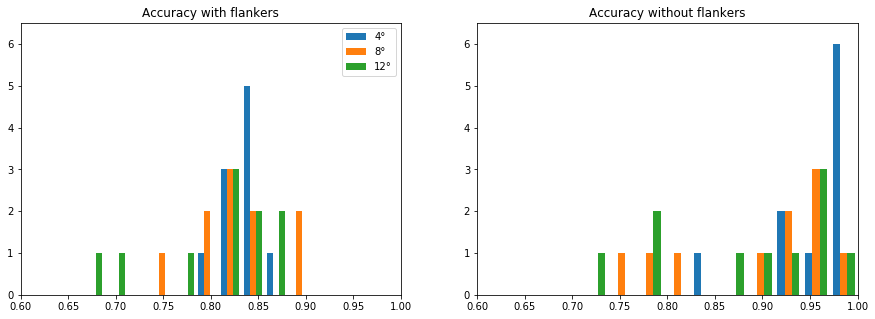

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(acc_ecc_flank)
plt.title('Accuracy with flankers')
plt.xlim(0.6,1.0)
plt.ylim(0,6.5)
plt.legend(['4°','8°','12°'])
plt.subplot(1,2,2)
plt.hist(acc_ecc_noflank)
plt.title('Accuracy without flankers')
plt.xlim(0.6,1.0)
plt.ylim(0,6.5)
plt.savefig('Accuracy flankers noflankers', dpi=300)

**Test difference between flankers and no-flankers**

In [10]:
acc_flank_mean=np.mean(acc_ecc_flank, axis=1)
acc_noflank_mean = np.mean(acc_ecc_noflank, axis=1)
acc_diff = acc_noflank_mean - acc_flank_mean
print(acc_diff)
print(np.mean(acc_diff), np.std(acc_diff))

[0.05886483 0.11965729 0.10973069 0.11345342 0.05474922 0.12034996
 0.07556758 0.13885373 0.01981539 0.12331393]
0.09343560285325897 0.03669427510815972


In [11]:
wilcoxon(acc_flank_mean, acc_noflank_mean)

WilcoxonResult(statistic=0.0, pvalue=0.005062032126267864)

**Calculate critical distance per participant**

In [5]:
crit_dis = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)): 
    data_sub = pd.read_csv(crowding_files[sub], sep='\t')
    
    for e in range(len(ecc)):
        tfr = []
        
        for i in range((total_trials-last_trials-1),(total_trials-1)):
            
            if data_sub["flanker_presence"][i]=="flankers" and data_sub["target_ecc"][i]==ecc[e]:
                tfr.append(data_sub["target_flank_ratio"][i])
    
        crit_dis[sub,e] = np.median(tfr) #sum(tfr)/len(tfr)

crit_dis_mean = np.median(crit_dis,axis=1) #np.mean(crit_dis,axis=1)     

In [13]:
#print('Critical distance per participant and eccentricity')
#print(crit_dis)
#print('Critical distance per participant across eccentricities')
#print(crit_dis_mean)

(0.2, 0.8)

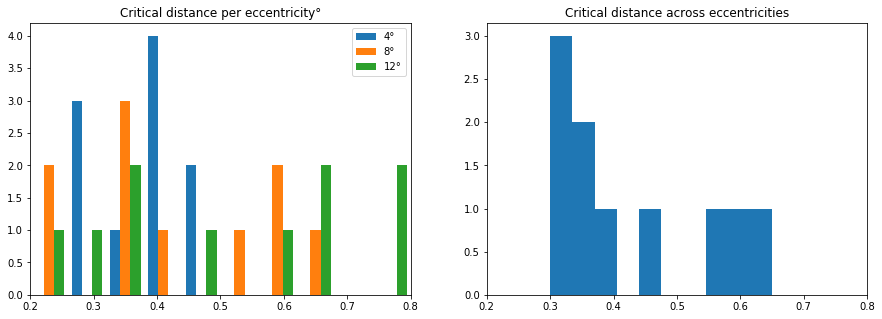

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(crit_dis)
plt.title('Critical distance per eccentricity°')
plt.xlim(0.2,0.8)
plt.legend(['4°','8°','12°'])

plt.subplot(1,2,2)
plt.hist(crit_dis_mean)
plt.title('Critical distance across eccentricities')
plt.xlim(0.2,0.8)

**Critical distance as a function of eccentricity**

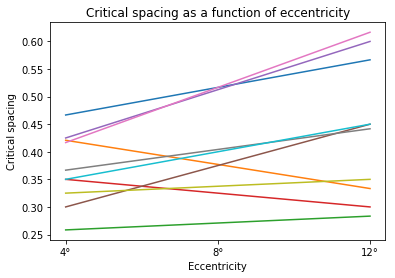

In [8]:
x = np.arange(3)
crit_dis_slope = np.zeros((len(subjects)))
plt.figure()

for sub in range(len(subjects)):
    regression = stats.linregress(x, crit_dis[sub])
    plt.plot([regression[1],regression[1]+regression[0]])
    crit_dis_slope[sub] = regression[0]
#print(crit_dis_slope)

plt.ylabel('Critical spacing')
plt.xlabel('Eccentricity')
plt.xticks((0,0.5,1),['4°','8°','12°'])
plt.title('Critical spacing as a function of eccentricity')
plt.savefig('Critical spacing as a function of eccentricity',dpi=300)

**Test value distribution**

In [16]:
#Critical distance mean across eccentricities
print(kstest(crit_dis_mean, 'norm'))

KstestResult(statistic=0.6179114221889526, pvalue=0.0003305224256820203)


In [17]:
#Critical distance slope
print(kstest(crit_dis_slope, 'norm'))

KstestResult(statistic=0.46513704271628464, pvalue=0.016755689090321445)


## 2) Search Task

In [15]:
trials = 720
blocks = 4 
trials_block = total_trials/blocks
ecc = [4,8,12]
set_size = [5,15,30]

In [16]:
search_files = []
for sub in range(len(subjects)):
    filename = 'C:\\Users\\Steffi\\Desktop\\PSR\\Data\\output_VS\\data_visualsearch_pp_%s.csv' %(subjects[sub])
    #filename = os.path.join(os.getcwd(),'Data/output_VS/data_visualsearch_pp_%s.csv' %(subjects[sub]))
    search_files.append(filename)

**Reaction times and accuracy per participant**

In [17]:
rt_ecc = np.zeros((len(subjects),len(ecc)))
acc_ecc = np.zeros((len(subjects),len(ecc)))
rt_ecc_std = np.zeros((len(subjects),len(ecc)))
acc_ecc_std = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    data_sub = pd.read_csv(search_files[sub], sep='\t')
    
    for e in range(len(ecc)):
        rts = []
        acc = []
        
        for n in range(len(data_sub)):
            if data_sub['target_ecc'][n]==ecc[e]:
                if data_sub['key_pressed'][n]== data_sub['target_orientation'][n]:
                    rts.append(data_sub["RT"][n])
                    acc.append(True)
                else:
                    acc.append(False)
        
        rt_ecc[sub,e]= np.mean(rts)#np.median(rts)
        acc_ecc[sub,e]= np.mean(acc) #np.median(acc)

rt_mean = np.mean(rt_ecc,axis=1) #np.median(rt_ecc,axis=1)
acc_mean = np.mean(acc_ecc, axis=1) #np.median(acc_ecc, axis=1)

In [21]:
#Mean reaction times per participant and eccentricity
#print(rt_ecc)

In [22]:
#Mean reaction times per participant across eccentricities
#print(rt_mean)

In [23]:
#Mean accuracy per participant and eccentricity
#print(acc_ecc)

In [24]:
#Mean accuracy per participant across eccentricities
#print(acc_mean)

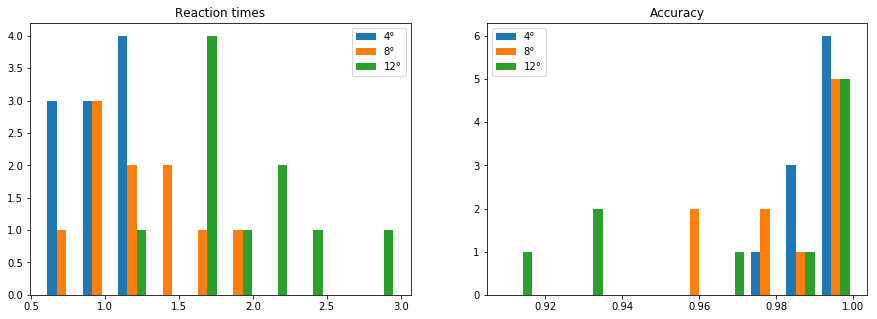

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(rt_ecc)
plt.title('Reaction times')
plt.legend(['4°','8°','12°'])
plt.subplot(1,2,2)
plt.hist(acc_ecc)
plt.title('Accuracy')
plt.legend(['4°','8°','12°'])

**Reaction times as a function of eccentricity**

[0.39066122 0.37377086 0.55958499 0.25583264 0.41278507 0.4828566
 0.84455331 0.53224081 0.49892749 0.56005063]


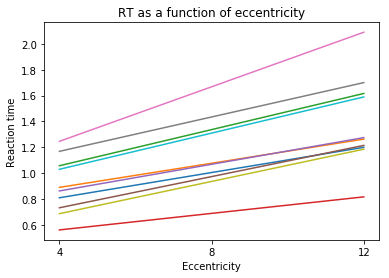

In [18]:
x = np.arange(3)
rt_ecc_slope = np.zeros((len(subjects)))
plt.figure()

for sub in range(len(subjects)):
    regression = stats.linregress(x, rt_ecc[sub])
    plt.plot([regression[1],regression[1]+regression[0]])
    rt_ecc_slope[sub] = regression[0]

print(rt_ecc_slope)

plt.ylabel('Reaction time')
plt.xlabel('Eccentricity')
plt.xticks((0,0.5,1),ecc)
plt.title('RT as a function of eccentricity')
plt.savefig('RT for ecc',dpi=300)

**Reaction times as a function of set size**

In [19]:
rt_setsize = np.zeros((len(subjects),len(set_size)))

for sub in range(len(subjects)):
    data_sub = pd.read_csv(search_files[sub], sep='\t')
    
    for s in range(len(set_size)):
        rts = []
        
        for n in range(len(data_sub)):
            if data_sub['set_size'][n]==set_size[s]:
                if data_sub['key_pressed'][n]== data_sub['target_orientation'][n]:
                    rts.append(data_sub["RT"][n])
        
        rt_setsize[sub,s]=np.mean(rts)
        
rt_setsize_mean = np.mean(rt_setsize,axis=0)

In [28]:
#print('Reaction time per participant and set size')
#print(rt_setsize)
#print('Reaction time per set size across participants')
#print(rt_setsize_mean)

[0.23196851 0.27703939 0.54881526 0.11776254 0.31455693 0.22192626
 0.77502988 0.60653816 0.33765279 0.41191151]


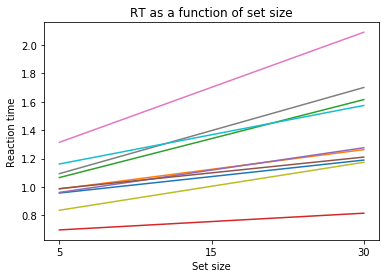

In [20]:
x = np.arange(3)
rt_setsize_slope = np.zeros((len(subjects)))
plt.figure()

for sub in range(len(subjects)):
    regression = stats.linregress(x, rt_setsize[sub])
    plt.plot([regression[1],regression[1]+regression[0]])
    rt_setsize_slope[sub] = regression[0]

print(rt_setsize_slope)

plt.ylabel('Reaction time')
plt.xlabel('Set size')
plt.xticks((0,0.5,1),set_size)
plt.title('RT as a function of set size')
plt.savefig('RT for set size',dpi=300)

**Inverse efficiency score**

In [42]:
inv_eff = rt_ecc/acc_ecc
inv_eff_mean = np.mean(inv_eff,axis=1)
#print(inv_eff)
#print(inv_eff_mean)

## Eyedata

In [21]:
def ang2pix(dist_in_deg,h,d,r): 
    import math 
    
    deg_per_px = math.degrees(math.atan2(0.5*h,d))/(0.5*r)
    dist_in_px = dist_in_deg/deg_per_px
    return dist_in_px 

In [22]:
# paths
os.chdir(r"C:\Users\Steffi\Desktop\PSR\Data")
base_dir = os.getcwd()
output_vs = os.path.join(base_dir,'Data','output_VS')#os.path.join(base_dir,'output_VS')
output_crwd = os.path.join(base_dir,'Data','output_crowding')#os.path.join(base_dir,'output_crowding')

In [23]:
# params 
vRes = 1050
hRes = 1680
ecc = [4,8,12]

gabor_size_deg = 2.2/2 #divide by 2 to get the radius
screen_distance = 50
screen_height = 30

gabor_size_pix = ang2pix(gabor_size_deg,screen_height,screen_distance,vRes)#radius in pixels
onedegree_pix = ang2pix(1,screen_height,screen_distance,vRes)
twodegree_pix = ang2pix(2,screen_height,screen_distance,vRes)#one degree in pixels

fixpos = np.array(((hRes/2),(vRes/2)))

In [24]:
eye_search_files = []
for sub in range(len(subjects)):
    #filename = os.path.join(output_vs,'pp-%s'%subjects[sub],'eyedata_visualsearch_pp_%s.asc' %subjects[sub])
    filename = 'C:\\Users\\Steffi\\Desktop\\PSR\\Data\\output_VS\\pp-%s\\eyedata_visualsearch_pp_%s.asc' %(subjects[sub],subjects[sub])
    eye_search_files.append(filename)

In [25]:
eye_crowd_files = []
for sub in range(len(subjects)):
    #filename = os.path.join(output_crwd,'pp-%s'%subjects[sub],'eyedata_crowding_pp_%s.asc' %subjects[sub])
    filename = 'C:\\Users\\Steffi\\Desktop\\PSR\\Data\\output_crowding\\pp-%s\\eyedata_crowding_pp_%s.asc' %(subjects[sub],subjects[sub])
    eye_crowd_files.append(filename)

**Gaze control crowding task**

In [36]:
gaze = np.zeros(len(subjects))
gaze_percentage1 = np.zeros(len(subjects))
gaze_percentage2 = np.zeros(len(subjects))

for sub in range(len(subjects)):
    eye_data = read_edf(eye_crowd_files[sub], 'start_trial', stop='stop_trial', debug=False)
    
    deviation = []
    over1 = []
    over2 = []
    
    for trial in range(len(eye_data)):
        x = eye_data[trial]['x']
        y = eye_data[trial]['y']
        time = eye_data[trial]['trackertime']
        eye_pos = np.array((x,y)).T
        displaytime = eye_data[0]['events']['msg'][3][0]
        
        for pos in range(len(eye_pos)):
            
            if time[pos] < (displaytime+500):
                distance = np.sqrt(np.sum((fixpos-eye_pos[pos])**2))

                deviation.append(distance)
                if distance > onedegree_pix:
                    over1.append(1)
                if distance > twodegree_pix:
                    over2.append(1)
    
    gaze_percentage1[sub]= sum(over1)/len(deviation)
    gaze_percentage2[sub]= sum(over2)/len(deviation)
    gaze[sub]=np.median(deviation)#np.mean(deviation)

In [37]:
print('Percent of trials with >1° deviation from fixation')
print(gaze_percentage1)
print('Percent of trials with >2° deviation from fixation')
print(gaze_percentage2)

Percent of trials with >1° deviation from fixation
[0.         0.         0.         0.         1.         0.59671533
 0.         0.27372263 0.         1.        ]
Percent of trials with >2° deviation from fixation
[0.         0.         0.         0.         1.         0.
 0.         0.01824818 0.         0.        ]


In [38]:
#Median deviation from fixation per participant
print(gaze)

[ 11.22274277  12.4036285    4.72016949  12.86584626 119.00987352
  31.95238566  20.56185485  28.56124997   7.46290827  40.95521945]


Text(0, 0.5, 'Pixels')

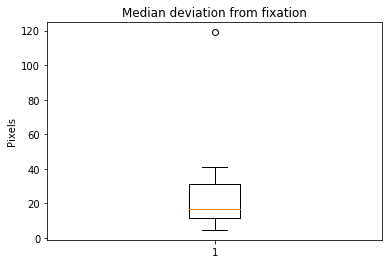

In [39]:
plt.boxplot(gaze)
plt.title('Median deviation from fixation')
plt.ylabel('Pixels')

**Number of fixations**

In [26]:
fix_ecc = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    eye_data = read_edf(eye_search_files[sub], 'start_trial', stop='stop_trial', debug=False)
    behv_data = pd.read_csv(search_files[sub],sep='\t')
    
    for e in range(len(ecc)):
        num_fix = []
    
        for trial in range(len(eye_data)):
            if behv_data['target_ecc'][trial]==ecc[e]:
                num_fix.append(len(eye_data[trial]['events']['Efix']))
    
        fix_ecc[sub,e] = np.mean(num_fix)

mean_fix = np.mean(fix_ecc,axis=1)

In [41]:
#Mean number of fixations per subject and eccentricity
#print(fix_ecc)
#Mean number of fixations per subject across eccentricities
#print(mean_fix)

Text(0.5, 1.0, 'Number of fixations across eccentricities')

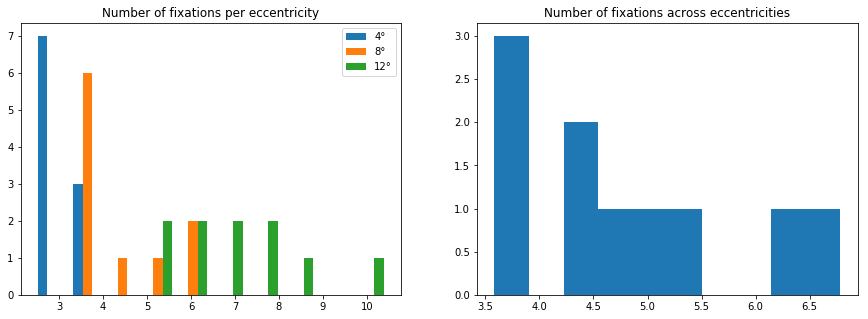

In [42]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(fix_ecc)
plt.title('Number of fixations per eccentricity')
plt.legend(['4°','8°','12°'])
plt.subplot(1,2,2)
plt.hist(mean_fix)
plt.title('Number of fixations across eccentricities')

**Number of fixations as a function of eccentricity**

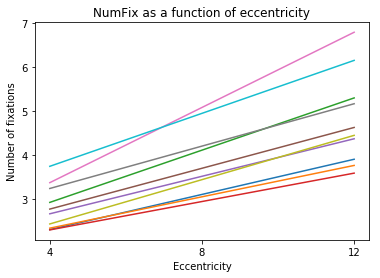

In [27]:
x = np.arange(3)
fix_ecc_slope = np.zeros((len(subjects)))
plt.figure()

for sub in range(len(subjects)):
    regression = stats.linregress(x, fix_ecc[sub])
    plt.plot([regression[1],regression[1]+regression[0]])
    fix_ecc_slope[sub] = regression[0]

#print(fix_ecc_slope)

plt.ylabel('Number of fixations')
plt.xlabel('Eccentricity')
plt.xticks((0,0.5,1),ecc)
plt.title('NumFix as a function of eccentricity')
plt.savefig('NumFix for ecc',dpi=300)

**Number of fixations as a function of set size**

In [28]:
fix_setsize = np.zeros((len(subjects),len(set_size)))

for sub in range(len(subjects)):
    eye_data = read_edf(eye_search_files[sub], 'start_trial', stop='stop_trial', debug=False)
    behv_data = pd.read_csv(search_files[sub],sep='\t')
    
    for s in range(len(set_size)):
        num_fix = []
    
        for trial in range(len(eye_data)):
            if behv_data['set_size'][trial]==set_size[s]:
                num_fix.append(len(eye_data[trial]['events']['Efix']))
    
        fix_setsize[sub,s] = np.mean(num_fix)

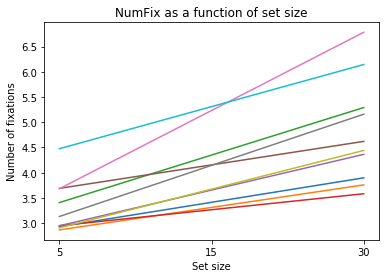

In [29]:
x = np.arange(3)
fix_setsize_slope = np.zeros((len(subjects)))
plt.figure()

for sub in range(len(subjects)):
    regression = stats.linregress(x, fix_setsize[sub])
    plt.plot([regression[1],regression[1]+regression[0]])
    fix_setsize_slope[sub] = regression[0]

#print(fix_setsize_slope)

plt.ylabel('Number of fixations')
plt.xlabel('Set size')
plt.xticks((0,0.5,1),set_size)
plt.title('NumFix as a function of set size')
plt.savefig('NumFix for setsize',dpi=300)

**Latency for leaving fixation**

In [46]:
#Using the duration of the first fixation - seems quite long though?
ecc_lat = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    eye_data = read_edf(eye_search_files[sub], 'start_trial', stop='stop_trial', debug=False)
    behv_data = pd.read_csv(search_files[sub],sep='\t')
    
    for e in range(len(ecc)):
        lat = []
    
        for trial in range(len(eye_data)):
            if behv_data['target_ecc'][trial]==ecc[e] and not eye_data[trial]['events']['Efix']==[]:
                
                lat.append(eye_data[trial]['events']['Efix'][0][2])
    
        ecc_lat[sub,e] = np.mean(lat)

mean_lat = np.mean(ecc_lat,axis=1)

In [47]:
#Mean latency for leaving fixation per subject and eccentricity
#print(ecc_lat)
#Mean latency for leaving fixation per subject across eccentricities
#print(mean_lat)

Text(0.5, 1.0, 'Latency for leaving fixation across eccentricities')

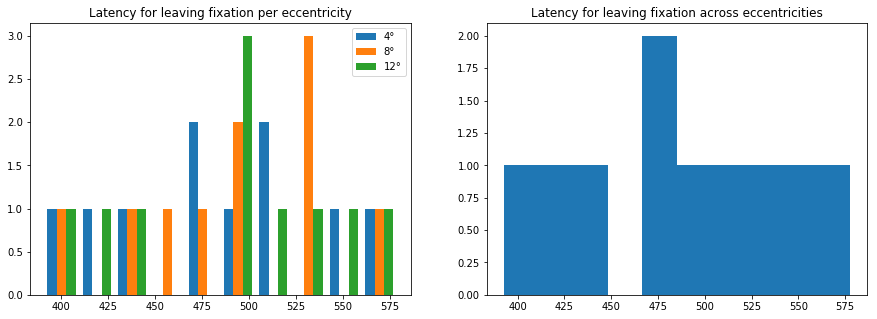

In [48]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(ecc_lat)
plt.title('Latency for leaving fixation per eccentricity')
plt.legend(['4°','8°','12°'])
plt.subplot(1,2,2)
plt.hist(mean_lat)
plt.title('Latency for leaving fixation across eccentricities')

In [49]:
## decided to try and compute saccade latency
# (the time from the presentation of the target to the commencement of the saccade)
# in this case it's from moment where display was shown (eye_data[0]['events']['msg'] [-3][0]
# until the start of first saccade

ecc_sacclat = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    eye_data = read_edf(eye_search_files[sub], 'start_trial', stop='stop_trial', debug=False)
    behv_data = pd.read_csv(search_files[sub],sep='\t')
    
    for e in range(len(ecc)):
        lat = []
    
        for trial in range(len(eye_data)):
            if behv_data['target_ecc'][trial]==ecc[e] and not eye_data[trial]['events']['Ssac']==[]:
                
                lat.append(eye_data[trial]['events']['Ssac'][0]-eye_data[trial]['events']['msg'][-3][0])
    
        ecc_sacclat[sub,e] = np.median(lat)#np.mean(lat)

mean_sacclat = np.median(ecc_sacclat,axis=1)#np.mean(ecc_sacclat,axis=1)


In [50]:
print('Median saccadic latency per subject and eccentricity')
print(ecc_sacclat)
print('Median saccadic latency per subject across eccentricities')
print(mean_sacclat)

Median saccadic latency per subject and eccentricity
[[228.  244.  231. ]
 [250.5 246.  253. ]
 [176.  184.  180. ]
 [216.  224.  218. ]
 [196.5 202.5 203.5]
 [177.5 180.  176. ]
 [260.  254.  250.5]
 [248.  246.5 248. ]
 [172.  186.  183. ]
 [215.  223.  223. ]]
Median saccadic latency per subject across eccentricities
[231.  250.5 180.  218.  202.5 177.5 254.  248.  183.  223. ]


Text(0.5, 1.0, 'Latency for start of 1st saccade across eccentricities')

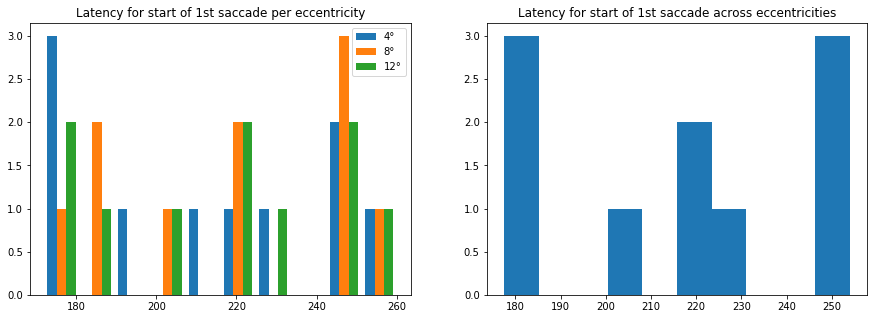

In [51]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(ecc_sacclat)
plt.title('Latency for start of 1st saccade per eccentricity')
plt.legend(['4°','8°','12°'])
plt.subplot(1,2,2)
plt.hist(mean_sacclat)
plt.title('Latency for start of 1st saccade across eccentricities')

**On-/Off-Object Fixation**

In [47]:
fix_dist = np.zeros((len(subjects),len(ecc)))
percent_on_object = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    distances = [[],[],[]]
    on_gabor = [[],[],[]]
    eye_data = read_edf(eye_search_files[sub], 'start_trial', stop='stop_trial', debug=False)
    behv_data = pd.read_csv(search_files[sub],sep='\t')
    
    for trial in range(len(eye_data)):
        #Inês' code to get stimulus positions
        target_srt = behv_data['target_position'][trial].replace(']','').replace('[','').split(' ')
        target_pos = [float(val) for i,val in enumerate(target_srt) if len(val)>1]
        distr_srt = behv_data['distractor_position'][trial].replace(']','').replace('[','').replace(',','').split(' ')
        distr_pos = [float(val) for i,val in enumerate(distr_srt) if len(val)>1]
        target_pos = [target_pos[0]+hRes/2,target_pos[1]+vRes/2]
        alldistr_pos = [distr_pos[i*2:(i+1)*2] for i in range((len(distr_pos))//2)] 
        alldistr_pos = [[alldistr_pos[i][0]+hRes/2,alldistr_pos[i][1]+vRes/2] for i in range((len(distr_pos))//2)]
        alldistr_pos.append(target_pos)
        
        fixations = eye_data[trial]['events']['Efix']
        
        for fix in range(len(fixations)):
            fixpos = np.array([fixations[fix][3],fixations[fix][4]])
            
            min_dis = 1000 #needs to be here
            for stim in range(len(alldistr_pos)):
                stimpos = np.array([alldistr_pos[stim][0],alldistr_pos[stim][1]])
                dis = np.sqrt(np.sum((fixpos-stimpos)**2))
                
                if dis < min_dis:
                    min_dis = dis
            
            if behv_data['target_ecc'][trial]==ecc[0]:
                distances[0].append(min_dis)
                if min_dis <= gabor_size_pix:
                    on_gabor[0].append(1)
            elif behv_data['target_ecc'][trial]==ecc[1]:
                distances[1].append(min_dis)
                if min_dis <= gabor_size_pix:
                    on_gabor[1].append(1)
            else:
                distances[2].append(min_dis)
                if min_dis <= gabor_size_pix:
                    on_gabor[2].append(1)

    fix_dist[sub,0] = np.mean(distances[0])
    fix_dist[sub,1] = np.mean(distances[1])
    fix_dist[sub,2] = np.mean(distances[2])
    
    percent_on_object[sub,0]=len(on_gabor[0])/len(distances[0])*100
    percent_on_object[sub,1]=len(on_gabor[1])/len(distances[1])*100
    percent_on_object[sub,2]=len(on_gabor[2])/len(distances[2])*100

mean_fix_dist = np.mean(fix_dist,axis=1)
mean_on_object = np.mean(percent_on_object, axis=1)

In [49]:
#Mean distance to next object at fixation per subject and eccentricity
print(fix_dist)
#Mean distance to next object at fixation per subject across eccentricities
print(mean_fix_dist)

[[101.87922703 126.02912998 121.21319621]
 [104.01086909 116.56686617 122.34028392]
 [ 96.55560649 122.7626714  121.34379189]
 [105.47123441 122.7318739  129.43611422]
 [ 95.56123673 118.9950688  124.88094105]
 [ 99.71855417 122.06220712 132.82541239]
 [ 99.76098642 117.85180121 124.35033583]
 [101.47281756 118.49074675 129.54011469]
 [ 98.78541498 119.29453188 118.39433793]
 [104.54422944 118.97438752 123.7898984 ]]
[116.37385107 114.30600639 113.55402326 119.21307418 113.14574886
 118.20205789 113.98770782 116.50122633 112.15809493 115.76950512]


In [50]:
#Percentage of on-object fixations per subject and eccentricity
print(percent_on_object)
#Percentage of on-object fixations per subject across eccentricities
print(mean_on_object)

[[13.33333333 12.30769231 14.67430208]
 [10.08130081  9.09090909 10.00769823]
 [17.2922252  12.63782867 13.36870027]
 [10.78767123 12.35813367  9.47630923]
 [15.01416431 11.84210526 13.38582677]
 [14.1509434  11.22770199 11.70343137]
 [10.89449541  7.2         7.20541401]
 [16.44498186 12.40105541 12.050257  ]
 [14.7566719  15.24008351 13.41235184]
 [17.24500526 15.58156547 13.53276353]]
[13.43844257  9.72663604 14.43291804 10.87403804 13.41403211 12.36069225
  8.43330314 13.63209809 14.46970242 15.45311142]


In [51]:
#without target fixation
fix_dist = np.zeros((len(subjects),len(ecc)))
percent_on_object = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    distances = [[],[],[]]
    on_gabor = [[],[],[]]
    eye_data = read_edf(eye_search_files[sub], 'start_trial', stop='stop_trial', debug=False)
    behv_data = pd.read_csv(search_files[sub],sep='\t')
    
    for trial in range(len(eye_data)):
        #Inês' code to get stimulus positions
        target_srt = behv_data['target_position'][trial].replace(']','').replace('[','').split(' ')
        target_pos = [float(val) for i,val in enumerate(target_srt) if len(val)>1]
        distr_srt = behv_data['distractor_position'][trial].replace(']','').replace('[','').replace(',','').split(' ')
        distr_pos = [float(val) for i,val in enumerate(distr_srt) if len(val)>1]
        target_pos = [target_pos[0]+hRes/2,target_pos[1]+vRes/2]
        alldistr_pos = [distr_pos[i*2:(i+1)*2] for i in range((len(distr_pos))//2)] 
        alldistr_pos = [[alldistr_pos[i][0]+hRes/2,alldistr_pos[i][1]+vRes/2] for i in range((len(distr_pos))//2)]
        #alldistr_pos.append(target_pos)
        
        fixations = eye_data[trial]['events']['Efix']
        
        for fix in range(len(fixations)):
            fixpos = np.array([fixations[fix][3],fixations[fix][4]])
            target_dis = np.sqrt(np.sum((fixpos-target_pos)**2))
            
            min_dis = 1000 #needs to be here
            
            for stim in range(len(alldistr_pos)):
                stimpos = np.array([alldistr_pos[stim][0],alldistr_pos[stim][1]])
                dis = np.sqrt(np.sum((fixpos-stimpos)**2))
                
                if dis < min_dis:
                    min_dis = dis
            
            if min_dis < target_dis or (min_dis > target_dis and target_dis > gabor_size_pix):#appending it only if non-target fixation
                if behv_data['target_ecc'][trial]==ecc[0]:
                    distances[0].append(min_dis)
                    if min_dis <= gabor_size_pix:
                        on_gabor[0].append(1)
                elif behv_data['target_ecc'][trial]==ecc[1]:
                    distances[1].append(min_dis)
                    if min_dis <= gabor_size_pix:
                        on_gabor[1].append(1)
                else:
                    distances[2].append(min_dis)
                    if min_dis <= gabor_size_pix:
                        on_gabor[2].append(1)

    fix_dist[sub,0] = np.mean(distances[0])
    fix_dist[sub,1] = np.mean(distances[1])
    fix_dist[sub,2] = np.mean(distances[2])
    
    percent_on_object[sub,0]=len(on_gabor[0])/len(distances[0])*100
    percent_on_object[sub,1]=len(on_gabor[1])/len(distances[1])*100
    percent_on_object[sub,2]=len(on_gabor[2])/len(distances[2])*100

mean_fix_dist = np.mean(fix_dist,axis=1)
mean_on_object = np.mean(percent_on_object, axis=1)

In [52]:
#Mean distance to next object at fixation per subject and eccentricity
print(fix_dist)
#Mean distance to next object at fixation per subject across eccentricities
print(mean_fix_dist)

[[140.20125388 141.54150064 125.68056033]
 [139.4678038  128.87844903 127.84908874]
 [126.33837312 133.55051637 128.93420417]
 [145.65759173 135.25001918 136.84421341]
 [131.05381808 132.77409652 131.12360735]
 [133.36003539 134.40768303 139.95489764]
 [127.2002496  127.94511703 131.26073782]
 [132.31610796 128.53625348 135.25218207]
 [139.63242643 131.321661   125.15565472]
 [135.47516525 133.0320682  130.06792909]]
[135.80777162 132.06511386 129.60769789 139.25060811 131.65050731
 135.90753869 128.80203482 132.03484784 132.03658071 132.85838751]


In [53]:
#Percentage of on-object fixations per subject and eccentricity
print(percent_on_object)
#Percentage of on-object fixations per subject across eccentricities
print(mean_on_object)

[[ 9.30232558 10.         13.81055676]
 [ 8.29187396  8.28025478  9.23913043]
 [13.34269663 11.81506849 12.39270386]
 [ 5.61594203  9.03141361  8.71751886]
 [11.37370753 10.66666667 12.6984127 ]
 [10.40787623 10.09564293 11.10425663]
 [ 9.65116279  6.95187166  6.90894569]
 [12.19822109 10.91234347 11.13675707]
 [12.41935484 13.61702128 12.70440252]
 [12.94247788 13.36336336 12.45192308]]
[11.03762745  8.60375306 12.516823    7.7882915  11.57959563 10.53592527
  7.83732671 11.41577388 12.91359288 12.91925477]


Text(0.5, 1.0, 'Percentage of on-object fixations across eccentricities')

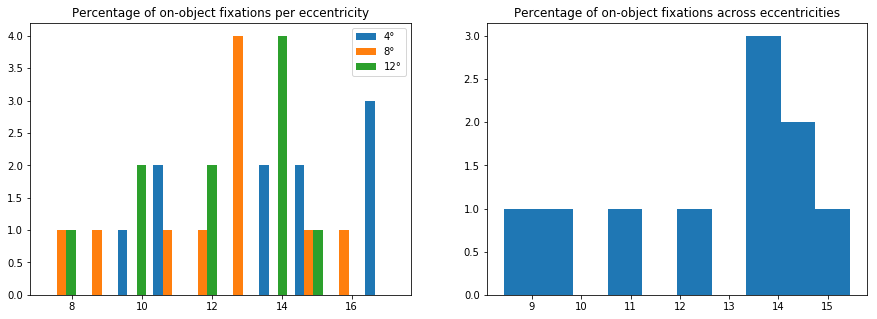

In [55]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(percent_on_object)
plt.title('Percentage of on-object fixations per eccentricity')
plt.legend(['4°','8°','12°'])
plt.subplot(1,2,2)
plt.hist(mean_on_object)
plt.title('Percentage of on-object fixations across eccentricities')

**Time between last fixation and response**

In [56]:
reaction_latency = np.zeros((len(subjects),len(ecc)))

for sub in range(len(subjects)):
    eye_data = read_edf(eye_search_files[sub], 'start_trial', stop='stop_trial', debug=False)
    behv_data = pd.read_csv(search_files[sub],sep='\t')
    
    for e in range(len(ecc)):
        timediff = []
    
        for trial in range(len(eye_data)):
            if behv_data['target_ecc'][trial]==ecc[e] and not eye_data[trial]['events']['Efix']==[]:
                #time between eyelink recorded response and end of fixation
                time = eye_data[trial]['events']['msg'][-2][0]-eye_data[trial]['events']['Efix'][-1][1]
                timediff.append(time)
    
        reaction_latency[sub][e]=np.mean(timediff) 

In [57]:
print('Time between last fixation and response per subject and eccentricity')
print(reaction_latency)

Time between last fixation and response per subject and eccentricity
[[264.26666667 235.25316456 247.57740586]
 [335.69166667 377.425      392.49166667]
 [396.825      366.7375     369.17083333]
 [ 94.53617021  92.97424893  86.05485232]
 [300.09166667 278.57563025 274.94166667]
 [222.72268908 238.64705882 243.05042017]
 [296.38888889 308.09583333 303.29583333]
 [293.15899582 246.35833333 231.3125    ]
 [235.52916667 248.44957983 261.78661088]
 [199.         219.87447699 185.05857741]]


## Correlation

**RT**

In [58]:
#Correlation of critical distance mean and RT
spearmanr(crit_dis_mean,rt_mean)

SpearmanrResult(correlation=0.4024465059906087, pvalue=0.24891109857761312)

In [59]:
#Correlation of critical distance slope and RT
spearmanr(crit_dis_slope,rt_mean)

SpearmanrResult(correlation=0.40729671426564323, pvalue=0.24271027029946393)

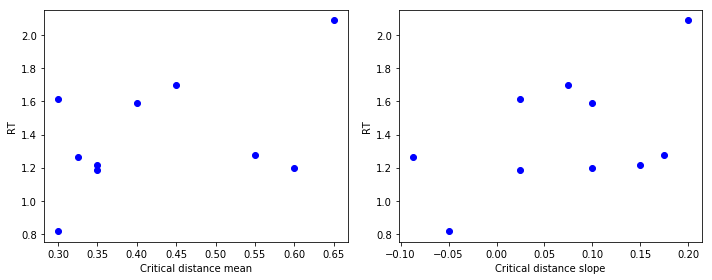

In [60]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(crit_dis_mean,rt_mean, 'bo')
plt.xlabel('Critical distance mean')
plt.ylabel('RT')

plt.subplot(1,2,2)
plt.plot(crit_dis_slope,rt_mean, 'bo')
plt.xlabel('Critical distance slope')
plt.ylabel('RT')

plt.tight_layout()

**RT / Eccentricity**

In [61]:
#Correlation of critical distance mean and RT/Ecc
spearmanr(crit_dis_mean,rt_ecc_slope)

SpearmanrResult(correlation=0.3475674369918894, pvalue=0.325077533765635)

In [62]:
#Correlation of critical distance slope and RT/Ecc
spearmanr(crit_dis_slope,rt_ecc_slope)

SpearmanrResult(correlation=0.44377104688644714, pvalue=0.1988934422361148)

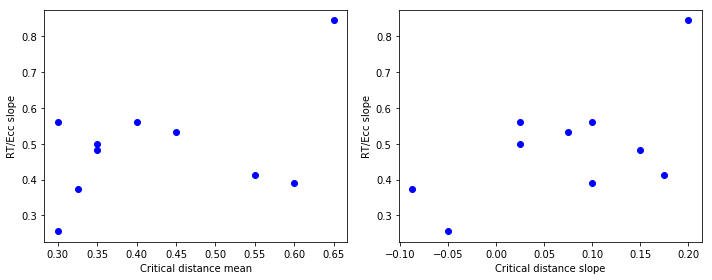

In [39]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(crit_dis_mean,rt_ecc_slope, 'bo')
plt.xlabel('Critical distance mean')
plt.ylabel('RT/Ecc slope')

plt.subplot(1,2,2)
plt.plot(crit_dis_slope,rt_ecc_slope, 'bo')
plt.xlabel('Critical distance slope')
plt.ylabel('RT/Ecc slope')
plt.savefig('RTEcc corr', dpi=300)
plt.tight_layout()


**RT / Set size**

In [64]:
#Correlation of critical distance mean and RT/Setsize
spearmanr(crit_dis_mean,rt_setsize_slope)

SpearmanrResult(correlation=0.37805580865784455, pvalue=0.2814111157974276)

In [65]:
#Correlation of critical distance slope and RT/Setsize
spearmanr(crit_dis_slope,rt_setsize_slope)

SpearmanrResult(correlation=0.2613993837824278, pvalue=0.465684706386463)

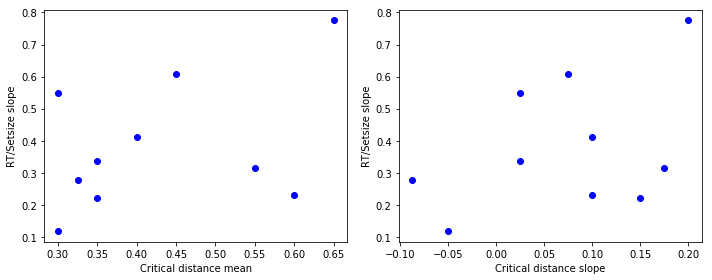

In [40]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(crit_dis_mean,rt_setsize_slope, 'bo')
plt.xlabel('Critical distance mean')
plt.ylabel('RT/Setsize slope')

plt.subplot(1,2,2)
plt.plot(crit_dis_slope,rt_setsize_slope, 'bo')
plt.xlabel('Critical distance slope')
plt.ylabel('RT/Setsize slope')
plt.savefig('RTSetsize corr', dpi=300)
plt.tight_layout()

**Inverse Efficiency Score**

In [67]:
#Correlation of critical distance mean and RT/Setsize
spearmanr(crit_dis_mean,inv_eff_mean)

SpearmanrResult(correlation=0.5122046439880474, pvalue=0.13012434210427876)

In [68]:
#Correlation of critical distance slope and RT/Setsize
spearmanr(crit_dis_slope,inv_eff_mean)

SpearmanrResult(correlation=0.37082238164483944, pvalue=0.2914682712989584)

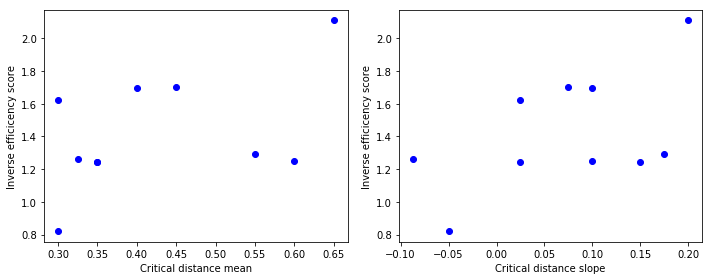

In [43]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(crit_dis_mean,inv_eff_mean, 'bo')
plt.xlabel('Critical distance mean')
plt.ylabel('Inverse efficicency score')

plt.subplot(1,2,2)
plt.plot(crit_dis_slope,inv_eff_mean, 'bo')
plt.xlabel('Critical distance slope')
plt.ylabel('Inverse efficicency score')
plt.savefig('InvEff corr', dpi=300)
plt.tight_layout()

**NumFix**

In [70]:
#'Correlation of critical distance mean and mean number of fixations
spearmanr(crit_dis_mean,mean_fix)

SpearmanrResult(correlation=0.3475674369918894, pvalue=0.325077533765635)

In [71]:
#'Correlation of critical distance slope and mean number of fixations
spearmanr(crit_dis_slope,mean_fix)

SpearmanrResult(correlation=0.49848254581765294, pvalue=0.14251791767625296)

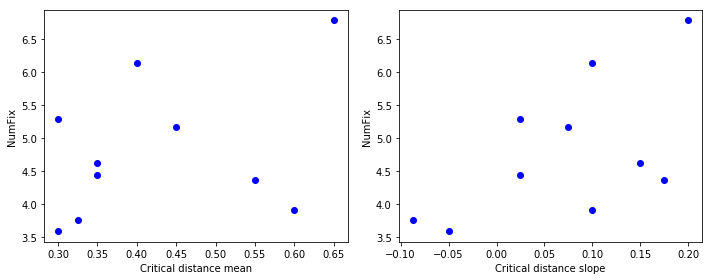

In [72]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(crit_dis_mean,mean_fix, 'bo')
plt.xlabel('Critical distance mean')
plt.ylabel('NumFix')

plt.subplot(1,2,2)
plt.plot(crit_dis_slope,mean_fix, 'bo')
plt.xlabel('Critical distance slope')
plt.ylabel('NumFix')

plt.tight_layout()

**NumFix / Eccentricity**

In [73]:
#Correlation of critical distance mean and NumFix/Ecc
spearmanr(crit_dis_mean,fix_ecc_slope)

SpearmanrResult(correlation=0.31707906532593416, pvalue=0.3720185798425297)

In [74]:
#Correlation of critical distance slope and NumFix/Ecc
spearmanr(crit_dis_slope,fix_ecc_slope)

SpearmanrResult(correlation=0.4255338805760452, pvalue=0.22017919518735943)

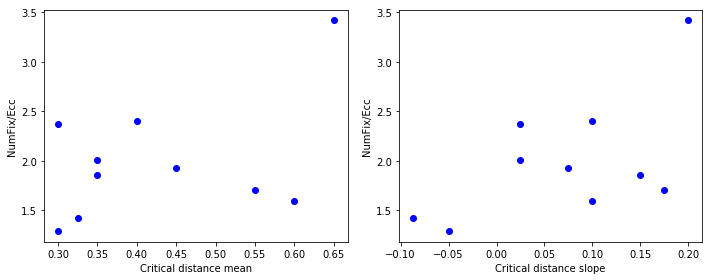

In [44]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(crit_dis_mean,fix_ecc_slope, 'bo')
plt.xlabel('Critical distance mean')
plt.ylabel('NumFix/Ecc')

plt.subplot(1,2,2)
plt.plot(crit_dis_slope,fix_ecc_slope, 'bo')
plt.xlabel('Critical distance slope')
plt.ylabel('NumFix/Ecc')
plt.savefig('FixEcc corr', dpi=300)
plt.tight_layout()

**NumFix / Set size**

In [76]:
#Correlation of critical distance mean and NumFix/Setsize
spearmanr(crit_dis_mean,fix_setsize_slope)

SpearmanrResult(correlation=0.4695209236557102, pvalue=0.17096550855966192)

In [77]:
#Correlation of critical distance slope and NumFix/Setsize
spearmanr(crit_dis_slope,fix_setsize_slope)

SpearmanrResult(correlation=0.4194548251392446, pvalue=0.2275515102242153)

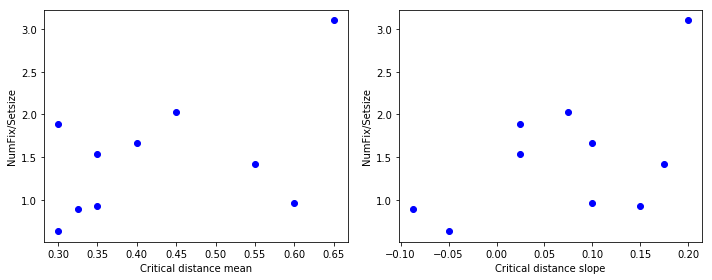

In [45]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(crit_dis_mean,fix_setsize_slope, 'bo')
plt.xlabel('Critical distance mean')
plt.ylabel('NumFix/Setsize')

plt.subplot(1,2,2)
plt.plot(crit_dis_slope,fix_setsize_slope, 'bo')
plt.xlabel('Critical distance slope')
plt.ylabel('NumFix/Setsize')
plt.savefig('Fixsetsize corr', dpi=300)
plt.tight_layout()

**On-Object Fixation**

In [54]:
#Correlation of critical distance mean and on-object fixation
spearmanr(crit_dis_mean,mean_on_object)

SpearmanrResult(correlation=0.018293022999573125, pvalue=0.9599974002377397)

In [55]:
#Correlation of critical distance slope and on-object fixation
spearmanr(crit_dis_slope,mean_on_object)

SpearmanrResult(correlation=0.024316221747202587, pvalue=0.9468397049085097)

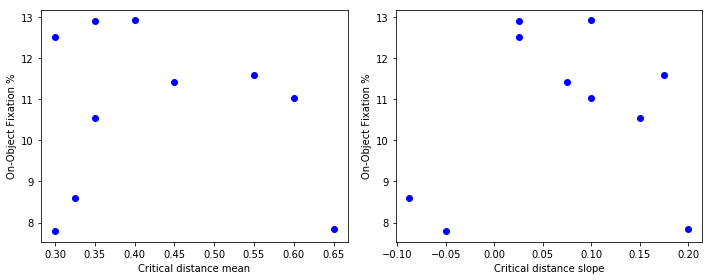

In [56]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(crit_dis_mean,mean_on_object, 'bo')
plt.xlabel('Critical distance mean')
plt.ylabel('On-Object Fixation %')

plt.subplot(1,2,2)
plt.plot(crit_dis_slope,mean_on_object, 'bo')
plt.xlabel('Critical distance slope')
plt.ylabel('On-Object Fixation %')
plt.savefig('OnObject corr', dpi=300)
plt.tight_layout()